<a href="https://colab.research.google.com/github/rant95/Advanced-artificial-intelligence/blob/main/TP10-GANLatent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a id='chap-tpganlatent'></a>

# Travaux pratiques : espace latent des GAN

Cette séance de travaux pratiques sert d’illustration à l’exploration
d’un espace latent et à l’évaluation des modèles génératifs. L’objectif
est de mieux comprendre comment manipuler et interpréter les codes
latents.

Pour cette séance, nous allons utiliser le jeu de données de chiffres
manuscrits MNIST mais les méthodes étudiées s’adaptent à n’importe quel
ensemble d’observations.

In [3]:
# Dernière version de torchvision pour MNIST
%pip install -U torchvision
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from torch import nn

## Qualité de la distribution apprise

Pour gagner du temps, nous allons récupérer des modèles préentraînés sur
MNIST. En particulier nous allons réutiliser un générateur de DCGAN
(*Deep Convolutional GAN*) entraîné sur MNIST, ainsi qu’une classifieur
entraîné sur les observations d’apprentissage.

*Note* : ces modèles ont été mis à disposition par [Chandan
Singh](https://github.com/csinva/gan-vae-pretrained-pytorch),
doctorant à UC Berkeley.

In [5]:
# Téléchargement des fichiers de poids
!wget -nc https://raw.githubusercontent.com/csinva/gan-vae-pretrained-pytorch/master/mnist_dcgan/weights/netG_epoch_99.pth
!wget -nc https://raw.githubusercontent.com/csinva/gan-vae-pretrained-pytorch/master/mnist_classifier/weights/lenet_epoch%3D12_test_acc%3D0.991.pth -O lenet.pth

--2022-05-28 11:44:43--  https://raw.githubusercontent.com/csinva/gan-vae-pretrained-pytorch/master/mnist_dcgan/weights/netG_epoch_99.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14306386 (14M) [application/octet-stream]
Saving to: ‘netG_epoch_99.pth’

netG_epoch_99.pth   100%[===================>]  13.64M  --.-KB/s    in 0.06s   

2022-05-28 11:44:44 (215 MB/s) - ‘netG_epoch_99.pth’ saved [14306386/14306386]

--2022-05-28 11:44:44--  https://raw.githubusercontent.com/csinva/gan-vae-pretrained-pytorch/master/mnist_classifier/weights/lenet_epoch%3D12_test_acc%3D0.991.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

Le classifieur est une architecture convolutive simple dite « LeNet5 ».
Le code ci-dessous permet de construire un tel modèle.

In [6]:
from collections import OrderedDict


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU()),
            ('flatten', nn.Flatten())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = self.fc(output)
        return output

lenet = LeNet5().eval()
lenet.load_state_dict(torch.load('lenet.pth'))

<All keys matched successfully>

Le générateur est un réseau convolutif à 5 couches. La dimension de
l’espace latent de ce modèle préappris est de 100. Les codes $ z $
ont été échantillonnés lors de l’apprentissage selon une loi normale.

In [7]:
class Generator(nn.Module):
    def __init__(self, out_channels=1, latent_dim=100, n_planes=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Le code Z est déconvolué
            nn.ConvTranspose2d(latent_dim, n_planes * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_planes * 8),
            nn.ReLU(inplace=True),
            # Activations (n_planes*8) x 4 x 4
            nn.ConvTranspose2d(n_planes * 8, n_planes * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_planes * 4),
            nn.ReLU(inplace=True),
            # Activations (n_planes*4) x 8 x 8
            nn.ConvTranspose2d(n_planes * 4, n_planes * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_planes * 2),
            nn.ReLU(inplace=True),
            # Activations (n_planes*2) x 16 x 16
            nn.ConvTranspose2d(n_planes * 2, n_planes, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_planes),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(n_planes, out_channels, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        input = input.unsqueeze(-1).unsqueeze(-1)
        output = self.main(input)
        return output

G = Generator().eval()
device = torch.device('cuda')
#"cuda" if torch.cuda.is_available else "cpu" # Utilise le GPU si disponible
G.load_state_dict(torch.load('netG_epoch_99.pth'))
#, map_location=device)

<All keys matched successfully>

## Question

En utilisant le générateur, écrivez une fonction `code2image` qui
prend en entrée un ou plusieurs codes `z` (de dimensions
$ (n, 100, 1, 1) $) et renvoie un tenseur d’autant d’images (de
dimensions $ (n, h, w) $). Générez et affichez quelques images de
chiffres manuscrits synthétiques.

## Correction

La fonction de conversion :

In [8]:
def code2image(code):
    z = torch.Tensor(code)
    with torch.no_grad():
        image = G(z)
    return np.array(image[0,0,:,:])

Affichage des images :

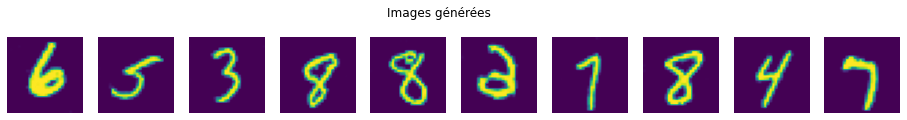

In [9]:
codes = torch.randn(10, 100)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 2))
for i, code in enumerate(codes):
    image = code2image(code.unsqueeze(0))
    fig.add_subplot(1, 10, i+1)
    plt.imshow(image)
    plt.axis("off")
fig.suptitle("Images générées")
plt.show()

Dans cette section, nous souhaitons tout d’abord regarder la
distribution des classes dans les chiffres synthétiques. Nous pouvons
déjà regarder la distribution des classes dans la base d’images MNIST :

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



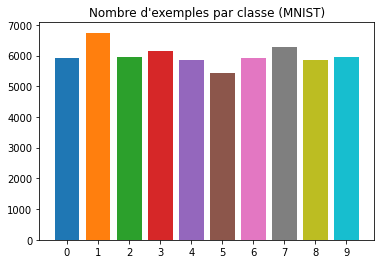

In [10]:
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm.notebook import tqdm, trange

mnist = MNIST(root="./mnist", train=True, download=True)
true_labels = np.array([label for _, label in mnist], dtype=int)

# Calcul du nombre d'occurrences de chaque valeur
occurrences = np.bincount(true_labels)

for i, count in enumerate(occurrences):
    plt.bar(i, count)
plt.xticks(range(0, 10))
plt.title("Nombre d'exemples par classe (MNIST)")
plt.show()

Pour les données synthétiques produites par le générateur, nous n’avons
pas l’information de la classe (le DCGAN utilisé pour générer ces
observations n’est pas conditionnel). À défaut, nous pouvons toutefois
utiliser un classifieur comme proxy pour étiqueter les images générées.

Le modèle LeNet5 prend en entrée des images de taille
$ 32\times32 $. Il est donc nécessaire de redimensionner les images
obtenues avec la fonction `code2image` qui produit des matrices
$ 28\times28 $. Vous pouvez utiliser la transformation ci-dessous à
cette fin :

In [11]:
from torchvision import transforms

resize = transforms.Resize(32)
# Sur une image PIL
print("-> Redimensionnement d'une image PIL")
print(mnist[0][0])
print(resize(mnist[0][0]))
# Sur un Tensor (dim n, w, h)
print("-> Redimensionnement d'un tenseur PyTorch")
tensor = torch.Tensor(image).unsqueeze(0)
print(tensor.shape)
print(resize(tensor).shape)

-> Redimensionnement d'une image PIL
<PIL.Image.Image image mode=L size=28x28 at 0x7F3B3C70F950>
<PIL.Image.Image image mode=L size=32x32 at 0x7F3B3C70FFD0>
-> Redimensionnement d'un tenseur PyTorch
torch.Size([1, 28, 28])
torch.Size([1, 32, 32])


## Question

Échantillonnez 1000 codes dans l’espace latent. Pour chaque code,
calculez l’image synthétique correspondante et utilisez LeNet5
préentraîné pour obtenir la classe de chiffre associée. Affichez dans un
histogramme le nombre d’occurrences de chaque classe de chiffres. Que
constatez-vous ? Vérifiez si besoin avec les données réelles du jeu de
données MNIST.

## Correction

In [30]:
n_codes = 10
latent_dim = 100
codes = torch.randn(n_codes, latent_dim)
labels = np.zeros(n_codes, dtype=int)

for idx, z in enumerate(tqdm(codes)):
    image = G(z.reshape(1, latent_dim))
    labels[idx] = torch.argmax(lenet(resize(image))).item()

  0%|          | 0/10 [00:00<?, ?it/s]

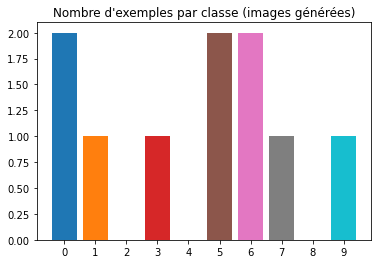

In [31]:
occurrences = np.bincount(labels)

for i, count in enumerate(occurrences):
    plt.bar(i, count)
plt.title("Nombre d'exemples par classe (images générées)")
plt.xticks(range(0, 10))
plt.show()

### Séparabilité des classes

Une façon d’évaluer si le modèle reproduit correctement la structure de
l’espace des données est considérer les frontières entre classes. Par
exemple, les images correspondant au chiffre 0 générées par le GAN
doivent se situer approximativement au même endroit dans l’espace des
observations que les chiffres 0 réels.

Pour mesurer cette propriété, une façon de faire est la suivante : -
étiqueter (manuellement ou avec un classifieur) $ n $ images
synthétiques - apprendre une SVM linéaire sur le jeu de données
d’entraînement - évaluer cette SVM linéaire un jeu de données de test -
évaluer la SVM linéaire sur les données synthétiques

La SVM linéaire va trouver des hyperplans séparateurs dans l’espace des
observations. Si le GAN conserve la structure de la distribution des
données, alors ces hyperplans doivent également séparer les données
synthétiques.

### Question

Appliquez cette méthode aux données ci-dessous. Que peut-on déduire des
scores relatifs de la SVM sur le jeu de test réel et sur le jeu de test
synthétique ?

### Correction

In [14]:
from sklearn.svm import LinearSVC

def to_np_dataset(mnist):
    X, y = [], []
    for data, label in mnist:
        X.append(data.numpy().ravel())
        y.append(label)
    return np.array(X), np.array(y)

train_mnist = MNIST(root="./mnist", train=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
X_train, y_train = to_np_dataset(train_mnist)
test_mnist = MNIST(root="./mnist", train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
X_test, y_test = to_np_dataset(test_mnist)

In [15]:
clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.9119

In [16]:
X_fake, y_fake = [], []

with torch.no_grad():
    for z in tqdm(codes):
        image = G(z.reshape(1, latent_dim))
        X_fake.append(image.numpy().ravel())
        y_fake.append(torch.argmax(lenet(resize(image))).item())

X_fake, y_fake = np.array(X_fake), np.array(y_fake)

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
clf.score(X_fake, y_fake)

0.8

In [18]:
clf = LinearSVC()
clf.fit(X_fake, y_fake)
clf.score(X_test, y_test)

0.3202

## Exploration de l’espace latent et contrôle de la génération

## Question

Que se passe-t-il quand la norme de $ z $ devient très grande ?

## Question

En utilisant les images synthétiques obtenues précédemment et leurs
pseudo-étiquettes, calculez pour chaque classe (chiffre) le barycentre
$ m_i $ de celle-ci dans l’espace latent.

On définit pour chaque paire de classses $ (i,j) $ la direction
$ d_{i,j} = m_j - m_i $. Choisissez deux classes (par exemple 0 et
8) et calculez la direction. Calculez différents codes
$ z' = z + \alpha \cdot d_{i,j} $ pour plusieurs valeurs de
$ \alpha $ et générez les images correspondantes. On choisira un
$ z $ qui correspond au chiffre de départ (par exemple 0). Comment
l’image se transforme-t-elle lorsque l’on suit la direction choisie ?

## Correction

In [32]:
barycenter_0 = np.mean(np.array(codes[labels == 0]), axis=0)
barycenter_8 = np.mean(np.array(codes[labels == 3]), axis=0)

In [33]:
plt.imshow(code2image(barycenter_0)) and plt.show()
plt.imshow(code2image(barycenter_8)) and plt.show()

ValueError: ignored

In [34]:
direction_08 = barycenter_8 - barycenter_0

In [35]:
code0 = codes[990]
image0 = code2image(code0)
plt.imshow(image0) and plt.show()

IndexError: ignored

In [51]:
for alpha in [0., 0.1, 0.15, 0.17, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0]:
    edit = code0 + alpha * direction_08
    plt.imshow(code2image(edit)) and plt.show()

ValueError: ignored

Lorsque les codes $ z $ de l’espace latent sont échantillonnés selon
une loi normale plutôt qu’une loi uniforme, il est en général considéré
préférable d’utiliser une interpolation sphérique plutôt qu’une
interpolation linéaire. En effet, pour une gaussienne, les courbes
d’iso-probabilité suivent les grands cercles.

La fonction `slerp` ci-dessous implémente une telle interpolation
selon le grand cercle :

In [24]:
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

## Question

Appliquez la même technique mais en utilisant une interpolation
sphérique plutôt qu’une interpolation linéaire. Visualisez la norme des
codes interpolés et comparez là à celle des codes obtenus par
interpolation linéaires. Commentez.

Visualisez les images interpolées. Qu’en pensez-vous ?